<a href="https://colab.research.google.com/github/sznajder/Notebooks/blob/master/DeepSets_PYTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 10: Deep Sets

In this workshop we will be looking at Deep Sets, which appeared in the Week 5 lecture on geometric deep learning.
We will use Deep Sets to solve some small (fairly uninteresting) problems - the workshop will be more on how to implement novel architectures in PyTorch, if they are not available as a library.

In [ ]:
import random
import itertools
import functools
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

# What is a DeepSet network?

Deep Sets are a particular architecture of neural network which are permutation-invariant with respect to their inputs. Such a network maps $n$ vectors in $\mathbb{R}^k$ to a single vector in $\mathbb{R}^r$, in such a way that the output is independent of the input order of the $n$ vectors. Furthermore, the same Deep Set network will be able to accept different numbers $n$ of input vectors.

## The permutation representation of the symmetric group

For now, we will set our input size to $\mathbb{R}^k = \mathbb{R}$, so our Deep Set network will be recieving $n$ scalars as input. We treat these scalars as living in the permutation representation $V_n = \mathbb{R}^n$ of the symmetric group, where each permutation acts by permuting coordinates (i.e. acts as a permutation matrix). There are two canonical subrepresentations: the trivial subrepresentation
$$ V_{triv} = \mathbb{R}(1, 1, \ldots, 1), $$
and the "standard" subrepresentation
$$ V_{std} = \{(x_1, \ldots, x_n) \in \mathbb{R}^n \mid x_1 + \cdots + x_n = 0\}.$$
Basic representation theory says that if a linear map $f \colon V_n \to V_n$ satisfies $f(\sigma v) = \sigma f(v)$ for all vectors $v \in V_n$ and permutations $\sigma$, the map must be block-diagonal with respect to $V_{triv}$ and $V_{std}$, and furthermore, it must be multiplication by a scalar on each of them. In more concrete terms, the matrix of $f$ must have all equal elements on the on-diagonal and on the off-diagonal:
$$ [f] = \begin{pmatrix} a & b & b & b \\ b & a & b & b \\ b & b & a & b \\ b & b & b & a \end{pmatrix} = aI + (J - I)b,$$
where $I$ is the identity matrix and $J$ is the all-ones matrix.
So there is only a two-dimensional space of permutation-equivariant maps $V_n \to V_n$ (rather than dimension $n^2$ in general). A little thought will show you that the only permutation-invariant biases that we can add as the affine part of a map are multiples of $(1, 1, \ldots, 1)$.

Regular neural networks are built out of layers that look like $\mathbb{R}^2 \to \mathbb{R}^3$ with affine maps (matrices plus a vector) in between. DeepSet networks are instead built out of layers that look like
$$ V_n \oplus V_n \to V_n \oplus V_n \oplus V_n, $$
with equivariant maps in between. In this example there would be a 15-dimensional space of affine equivariant maps.

## Implementing the DeepSet blocks

From a technical standpoint, we want to teach PyTorch about a new kind of module
it can use to build neural networks. We will specify the input and output dimensions ($2$ and $3$ above), but _not_ about the $n$ that will be used (since it is variable). This layer needs to then store the $2(2 \times 3) + 3 = 15$ parameters, and implement the operation which actually performs the linear map (this implementation needs to be able to accept different input cardinalities $n$). The parameters will automatically be available for training, we don't need to provide any code to do that.

### Tensor details

We will implement a `DeepSetLayer` which takes $V_n^{\oplus k} \to V_n^{\oplus r}$, i.e. it maps $n$ vectors of length $k$ to $n$ vectors of length $r$, for variable length $n$. Let us ignore the batch coordinate for now: we will be transforming a tensor of shape $(k, n)$ to one of shape $(k, r)$. The discussion above shows that the linear map must be of the form
$$ \alpha \otimes I + \beta \otimes J,$$
where $I$ is the identity matrix, $J$ is the all-ones matrix, and $\alpha, \beta$ are arbitrary $r \times k$ matrices. The additive bias must be of the form
$$ +\gamma \otimes (1, 1, \ldots, 1). $$

**Technical note:** One can write the linear map in many different ways. We could for example choose the canonical projectors to the subrepresentations,
$$ P_{triv}(x_1, \ldots, x_n) = \frac{x_1 + \cdots + x_n}{n}(1, \ldots, 1), \quad P_{std} = I - P_{triv},$$
and instead parameterise equivariant maps by $\alpha \otimes P_{triv} + \beta \otimes P_{std}$. Notice that the definition of $P_{triv}$ and $P_{std}$ depend on $n$ (in the forward pass, there will be a division by $n$). This really has an impact on the network (at least for small networks): for instance using $J$ and $I$ a network is better at calculating the sum of its inputs, wheras using the projectors it is better at calculating the mean.

**Technical note 2:** When implementing $\alpha \otimes I + \beta \otimes J$, we don't actually want to multiply by the matrices $I$ and $J$. There is no point to multiplying by $I$ (just use the input directly), and multiplication by $J$ is better expressed by summing up the coordinates of the vector and then doing tensor broadcasting.

In [ ]:
def rand(shape, low, high):
    """Tensor of random numbers, uniformly distributed on [low, high]."""
    return torch.rand(shape) * (high - low) + low


class DeepSetLayer(nn.Module):
    """
    DeepSetLayer(in_blocks, out_blocks) takes shape (batch, in_blocks, n) to (batch, out_blocks, n).
    Each block of n scalars is treated as the S_n permutation representation, and maps between blocks are
    S_n-equivariant.
    """
    def __init__(self, in_blocks, out_blocks):
        super().__init__()
        
        self.in_blocks = in_blocks
        self.out_blocks = out_blocks
        
        # Initialisation tactic copied from nn.Linear in PyTorch
        lim = (in_blocks)**-0.5 / 2

        # Alpha corresponds to the identity, beta to the all-ones matrix, and gamma to the additive bias.
        self.alpha = torch.nn.Parameter(data=rand((out_blocks, in_blocks), -lim, lim))
        self.beta = torch.nn.Parameter(data=rand((out_blocks, in_blocks), -lim, lim))
        self.gamma = torch.nn.Parameter(data=rand((out_blocks), -lim, lim))
    
    def forward(self, x):
        # x has shape (batch, in_blocks, n)
        return (
            torch.einsum('...jz, ij -> ...iz', x, self.alpha)
            + torch.einsum('...jz, ij -> ...iz', x.sum(axis=-1)[..., None], self.beta)
            + self.gamma[..., None]
        )


# Test if we got our tensor nonsense right. For a batch size of 6, and n = 7,
# a DeepSetLayer(2, 3) should map shape (6, 2, 7) to (6, 3, 7).
DeepSetLayer(2, 3)(torch.rand((6, 2, 7))).shape

torch.Size([6, 3, 7])

## Extracting an invariant

We eventually want an output of a single vector in $\mathbb{R}^r$, rather than $n$ vectors in $\mathbb{R}^r$, which can be either used directly, or fed into a standard neural network. The `DeepSetSum` block implements this, by summing along the last tensor dimension. (Representation-theoretically, we are projecting to a direct sum of trivial representations, which turns our equivariant network into an invariant network).


In [ ]:
class DeepSetSum(nn.Module):
    """
    DeepSetSum(blocks) takes a deep set layer of shape (batch, blocks, n) to a regular layer
    of shape (batch, blocks) by projecting to the trivial representation and then extracting
    a coordinate, eg
        (1, 2, 3, 4) => project to trivial => (2.5, 2.5, 2.5, 2.5) => extract component => 2.5
    """
    def __init__(self, blocks):
        super().__init__()
        
        lim = (blocks)**-0.5 / 2
        self.weight = torch.nn.Parameter(data=rand(blocks, -lim, lim))
        self.bias = torch.nn.Parameter(data=rand(blocks, -lim, lim))
    
    def forward(self, x):
        return x.sum(dim=-1) * self.weight + self.bias
  
# Check shapes. A DeepSetSum(3) should take shape (batch, 3, n) to (batch, 3)
DeepSetSum(3)(torch.rand((6, 3, 7))).shape

torch.Size([6, 3])

# Problem 1: Find the sum of a set of scalars.

Given a multiset of scalars in the range $[-1, 1]$, output their sum.
This is (of course) a rather boring task for a neural network, but it serves as somewhere we can contrast the Deep Set architecture with a more standard approach.

We're using the following utility function to count the parameters (as in the number of trainable scalars) in a model:

In [ ]:
def count_parameters(model):
    """Return the number of trainable parameters of a model (the total number of scalars)."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## A standard neural network

With a standard neural network, we will have to fix our number of scalars $n$ in advance. Other than that, it is business as usual. We just generate test data on-the-fly for this simple problem.

In [ ]:
# Number of numbers to add (needs to be fixed for the standard network!)
input_size = 4

# Model structure.
model = nn.Sequential(
    nn.Linear(input_size, 20),
    nn.ReLU(),
    nn.Linear(20, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
)
print(f"Model has {count_parameters(model)} parameters")

# Learning rate and loss function.
optimiser = torch.optim.SGD(model.parameters(), lr=0.005)
loss_function = nn.L1Loss()

# Samples each epoch, and batches for gradient descent.
epochs = 30
sample_size = 10_000
batch_size = 16

Model has 321 parameters


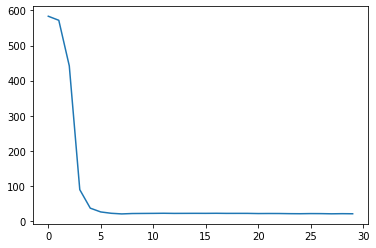

Final loss is 20.522085189819336


In [ ]:
# Training loop
recorded_loss = torch.zeros(epochs)

for epoch in range(epochs):
    samples = rand((sample_size, input_size), -1, 1)
    total_loss = 0.0
    
    for i in range(0, sample_size, batch_size):
        batch_in = samples[i:i+batch_size]
        batch_target = batch_in.sum(dim=-1)[:, None]
        
        optimiser.zero_grad()
        result = model(batch_in)
        loss = loss_function(result, batch_target)
        total_loss += float(loss)
        loss.backward()
        optimiser.step()
    
    recorded_loss[epoch] = total_loss
      
fig, ax = plt.subplots()
ax.plot(recorded_loss)
plt.show()
print(f"Final loss is {recorded_loss[-1]}")

## Evaluation

The network is doing fairly well, and by examining some explicit outputs we can see that it's almost reached invariance:

In [ ]:
examples = torch.tensor([
    [0, 1, 0, 1],
    [1, 0, 1, 0],
    [-1, 1, -1, 1],
    [1, -1, 1, -1],
    [0, 0, 0, 0],
], dtype=torch.float)

with torch.no_grad():
    results = model(examples)

results.numpy().round(2)

array([[ 2.  ],
       [ 2.01],
       [ 0.01],
       [-0.03],
       [-0.01]], dtype=float32)

## A Deep Set network

In [ ]:
# Model structure. Note that we don't specify the input size anywhere!!!
model = nn.Sequential(
    DeepSetLayer(1, 20),
    nn.ReLU(),
    DeepSetLayer(20, 10),
    nn.ReLU(),
    DeepSetLayer(10, 1),
    DeepSetSum(1),
)
print(f"Model has {count_parameters(model)} parameters")

# Learning rate and loss function.
optimiser = torch.optim.SGD(model.parameters(), lr=0.005)
loss_function = nn.L1Loss()

# Samples each epoch, and batches for gradient descent.
epochs = 30
sample_size = 10_000
batch_size = 16

# Input set sizes to use during training
input_sizes = [3, 4]

Model has 493 parameters


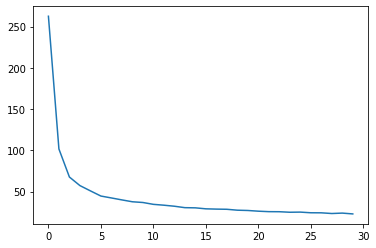

Final loss is 22.87281608581543


In [ ]:
import random

data = []
for n_inputs in input_sizes:
    samples = torch.from_numpy(np.random.random_sample((sample_size//len(input_sizes), 1, n_inputs))).float()
    for i in range(0, samples.shape[0], batch_size):
        data += [samples[i:i+batch_size]]


recorded_loss = torch.zeros(epochs)

for epoch in range(epochs):
    total_loss = 0.0
    random.shuffle(data)
    for samples in data:
        batch_in = samples
        batch_target = batch_in.sum(-1)
        
        optimiser.zero_grad()
        result = model(batch_in)
        loss = loss_function(result, batch_target)
        total_loss += float(loss)
        loss.backward()
        optimiser.step()
    
    recorded_loss[epoch] = total_loss
    # print(f"Epoch {epoch}, loss {total_loss}")

fig, ax = plt.subplots()
ax.plot(recorded_loss)
#ax.set_ylim([0, 1])
plt.show()
print(f"Final loss is {recorded_loss[-1]}")

In [ ]:
examples = torch.tensor([
    [0, 1, 0, 1],
    [1, 0, 1, 0],
    [-1, 1, -1, 1],
    [1, -1, 1, -1],
    [0, 0, 0, 0],
], dtype=torch.float).reshape(-1, 1, 4)

with torch.no_grad():
    results = model(examples)

results.numpy().round(2)

array([[ 1.99],
       [ 1.99],
       [-0.39],
       [-0.39],
       [-0.55]], dtype=float32)